In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, random

import sklearn
from sklearn import ensemble, model_selection, preprocessing, tree, linear_model, neighbors
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix

### I'm using  plot_confusion_matrix  function taken from kernel found on Kaggle
####  Credit to [George Fisher](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix/notebook) who has licensed it under an [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0)  open source license

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### A function for pickling the classifiers (not necessary)

In [3]:
def pickle_classifier(filepath, classifier):
    """Function to automate the pickling of a classifier
    """
    with open(filepath, 'wb') as f:
        pickle.dump(classifier, f)

def load_pickled_classifier(filepath):
    """Function to load a pickled classifier
    """
    with open(filepath, 'rb') as f:
        return pickle.load(f)

In [4]:
df = pd.read_json('..\\data\\cleaned_df_numerical_columns_only.json')
df = df.astype(float)
# moving converted to last column (was thinking of using random.shuffle)
df_converted = df['converted']
df = df.drop(['converted'], axis=1)
df['converted'] = df_converted

redundant_columns = [
    'score_normalized',
    'days_since_signup_normalized'
]
df.drop(redundant_columns, axis=1, inplace=True)

In [5]:
df.head()

,days_since_signup,completed_form,visited_pricing,registered_for_webinar,attended_webinar,is_manager,acquisition_channel_cold_call,acquisition_channel_cold_email,acquisition_channel_organic_search,acquisition_channel_paid_leads,...,is_sales,is_marketing,is_other,is_web_ind,is_financials_ind,is_furniture_ind,is_transportation_ind,is_manufacturing_ind,is_scandesign_ind,converted
0,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10,27.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1000,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Random Forest

In [6]:
X = df.drop(columns=['converted'])
X = preprocessing.scale(X)
y = df.converted

In [8]:
for i in range(1, 11):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    n_trees = 500
    clf = ensemble.RandomForestClassifier(max_features='auto', n_estimators=n_trees, random_state=None, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\random_forest.pickle', clf)

Test 1 Accuracy:	1.0
Test 2 Accuracy:	1.0
Test 3 Accuracy:	1.0
Test 4 Accuracy:	0.99992
Test 5 Accuracy:	1.0
Test 6 Accuracy:	0.99996
Test 7 Accuracy:	1.0
Test 8 Accuracy:	0.99996
Test 9 Accuracy:	0.99996
Test 10 Accuracy:	1.0


In [9]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[19301,     0],
       [    0,  5699]], dtype=int64)

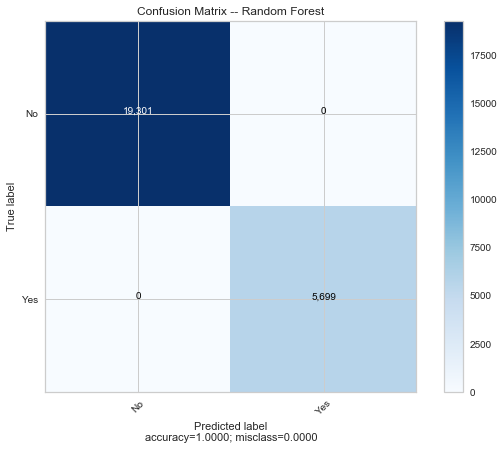

In [10]:
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- Random Forest")

In [11]:
print(clf.decision_path(X))
print(clf.feature_importances_)

(<100000x1117652 sparse matrix of type '<class 'numpy.int64'>'
	with 386940424 stored elements in Compressed Sparse Row format>, array([      0,    2663,    4286,    4289,    4292,    4295,    9294,
         12773,   13516,   16969,   20442,   20853,   22444,   25609,
         26286,   27641,   29916,   31629,   32780,   37361,   40246,
         41393,   42300,   46215,   50584,   54525,   56634,   58059,
         60734,   61353,   61356,   64009,   66846,   68659,   74140,
         77723,   79220,   80855,   80874,   83199,   84558,   86427,
         89914,   92941,   92944,   97119,   97676,   99867,  103234,
        103761,  103764,  103767,  106016,  109169,  109560,  110819,
        115402,  115863,  121348,  122751,  122754,  124009,  124758,
        130097,  132418,  133327,  134514,  134517,  134788,  137819,
        140342,  142681,  147424,  147427,  151642,  156105,  159208,
        163825,  165082,  167409,  167412,  170493,  170500,  171155,
        174962,  177061,  17706

##### ROC Curve

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10))
# roc_viz = ROCAUC(clf)
# roc_viz.score(X_test,y_test)

# roc_viz.poof()

## Logistic Regression

In [12]:
X = df.drop(columns=['converted'])
X = preprocessing.scale(X)
y = df.converted

In [13]:
for i in range(1, 11):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = linear_model.LogisticRegression(random_state=None, solver='lbfgs', n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\logistic_regression.pickle', clf)

Test 1 Accuracy:	0.99504
Test 2 Accuracy:	0.99528
Test 3 Accuracy:	0.9948
Test 4 Accuracy:	0.99532
Test 5 Accuracy:	0.99496
Test 6 Accuracy:	0.99484
Test 7 Accuracy:	0.99496
Test 8 Accuracy:	0.99488
Test 9 Accuracy:	0.99468
Test 10 Accuracy:	0.99552


In [14]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[19202,   102],
       [   10,  5686]], dtype=int64)

In [15]:
print(clf.decision_function(X))
print(clf.decision_function(X).mean())
pd.DataFrame(clf.decision_function(X)>0).describe()

[  1.84305783  -4.84057182 -12.55518274 ... -38.23453234 -21.57981147
  12.86152362]
-17.11048369402891


,0
count,100000
unique,2
top,False
freq,76831


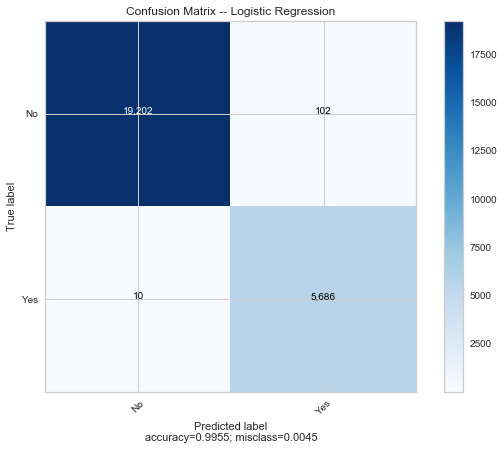

In [16]:
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- Logistic Regression")

## Linear Regression

In [17]:
X = df.drop(columns=['converted'])
X = preprocessing.scale(X)
y = df.converted

In [19]:
for i in range(1, 11):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = linear_model.LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\linear_regression.pickle', clf)

Test 1 Accuracy:	0.476899108097588
Test 2 Accuracy:	0.47375879213583466
Test 3 Accuracy:	0.4788439521767435
Test 4 Accuracy:	0.47842726508382644
Test 5 Accuracy:	0.47538180074100567
Test 6 Accuracy:	0.4767168336630939
Test 7 Accuracy:	0.4787464444310237
Test 8 Accuracy:	0.4794903647472636
Test 9 Accuracy:	0.4756155481840401
Test 10 Accuracy:	0.47364192273653777


In [20]:
y_pred = clf.predict(X_test)
y_pred = [0 if c <= 0.5 else 1 for c in y_pred]
cm = confusion_matrix(y_test, y_pred)
cm

array([[19322,    25],
       [ 3113,  2540]], dtype=int64)

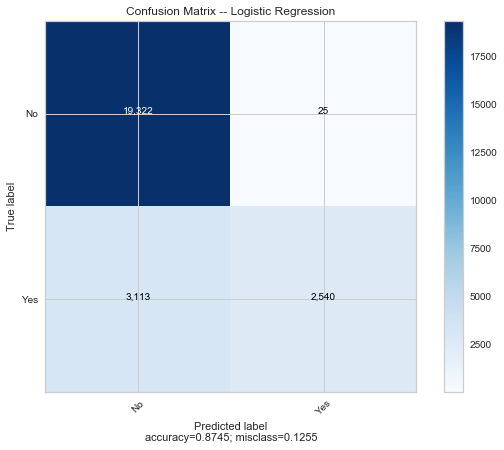

In [21]:
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- Linear Regression")

## K Nearest Neighbor (KNN)

In [25]:
X = df.drop(columns=['converted'])
X = preprocessing.scale(X)
y = df.converted

#### KNN Regressor

In [26]:
for i in range(1, 11):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = neighbors.KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\knn_regressor.pickle', clf)

Test 1 Accuracy:	0.4876572947219172
Test 2 Accuracy:	0.47024897039750374
Test 3 Accuracy:	0.47234856613595455
Test 4 Accuracy:	0.4783212746599473
Test 5 Accuracy:	0.46550718925266243
Test 6 Accuracy:	0.48532773745887714
Test 7 Accuracy:	0.47557076787830044
Test 8 Accuracy:	0.47111858259450307
Test 9 Accuracy:	0.4743349931797622
Test 10 Accuracy:	0.4805021690879286


In [29]:
y_pred = clf.predict(X_test)
y_pred = [0 if c <= 0.5 else 1 for c in y_pred]
cm = confusion_matrix(y_test, y_pred)
cm

array([[18968,   270],
       [ 2285,  3477]], dtype=int64)

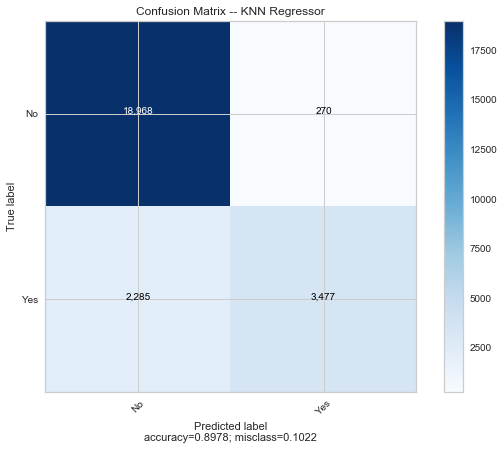

In [30]:
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- KNN Regressor")

#### KNN Classifier

In [31]:
for i in range(1, 11):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\knn_classifier.pickle', clf)

Test 1 Accuracy:	0.89704
Test 2 Accuracy:	0.89724
Test 3 Accuracy:	0.89824
Test 4 Accuracy:	0.8968
Test 5 Accuracy:	0.89664
Test 6 Accuracy:	0.89904
Test 7 Accuracy:	0.89796
Test 8 Accuracy:	0.89796
Test 9 Accuracy:	0.8974
Test 10 Accuracy:	0.89612


In [32]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[18998,   337],
       [ 2260,  3405]], dtype=int64)

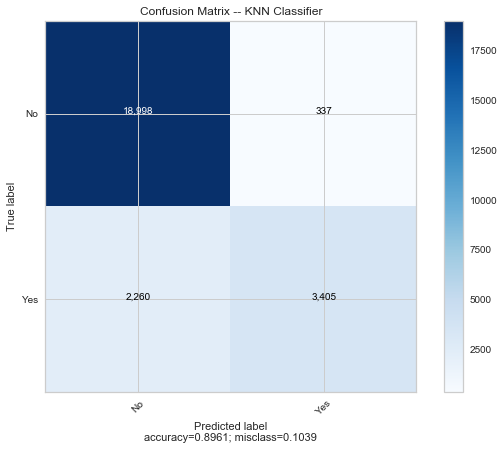

In [33]:
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- KNN Classifier")